## Objective

We want to use neural network to approximate diffusion maps with parts of given data.

## Diffusion maps

In [1]:
using MAT , PyPlot , LinearAlgebra , Random , StatsBase , Clustering , Images

In [2]:
function partition(Z , L)
    # Randomly pick L points from Z
    idx = sort(sample(1:size(Z , 1) , L , replace = false)) ;
    
    X = Z[idx , :] ;
    
    return X , idx ;
end

partition (generic function with 1 method)

In [3]:
function DiffMap(X , c = 3 , sigma = 7)
    # get_K
    n = size(X,1) ;
    K = zeros(n,n) ;
    for ii = 1 : n
        for jj = ii+1 : n
            K[ii,jj] = sum((X[ii,:] - X[jj,:]).^2) ;
            K[jj,ii] = K[ii,jj] ;
        end
    end
    
    # local scaling
    # sigma : choose the 7th nearest point as scale for each points
    temp = sort(K , dims = 2 , alg = QuickSort) ;
    temp = temp[: , sigma] ;
    K = exp.(-K ./(sqrt.(temp*transpose(temp)))) ;
    
    # get_Ppron
    Dsqinv = 1 ./ sqrt.(sum(K , dims = 2)) ;
    K = K .* Dsqinv .* transpose(Dsqinv) ;
    
    # get_eig
    S , K = eigen(K) ; # S is eigenvalue and K is eigenvector
    print("the imag of eigenvalue : " , maximum(abs.(imag(S)))) ;
    S = real(S) ;
    p = partialsortperm(S , 2 : c+1 , rev = true) ;
    S = S[p] ;
    K = K[: , p] ;
    print(" ,the imag of eigenvector : " , maximum(abs.(imag(K))) , "\n") ;
    K = real(K) ;
    
    return K .* Dsqinv .* transpose(S) ;
end

DiffMap (generic function with 3 methods)

In [4]:
function Color1(group)
    dict = Dict(1 => "red" , 2 => "green" , 3 => "blue" , 4 => "black" , 5 => "brown" , 6 => "cyan" , 7 => "orange") ;
    
    cc = Array{String}(undef, size(group , 1)) ;
    for ii = 1 : size(group , 1)
        cc[ii] = dict[group[ii]] ;
    end
    
    return cc ;
end

Color1 (generic function with 1 method)

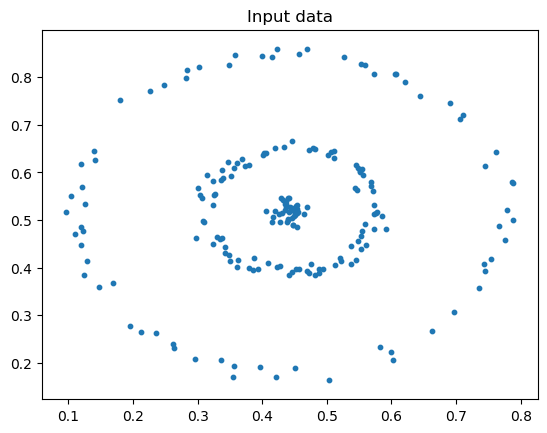

PyObject Text(0.5, 1, 'Input data')

In [5]:
file = matread("Data2.mat")
X = file["data"] ;
x_train , ~ = partition(X , 200)
scatter(x_train[:,1] , x_train[:,2] , s = 10)
title("Input data")

the imag of eigenvalue : 

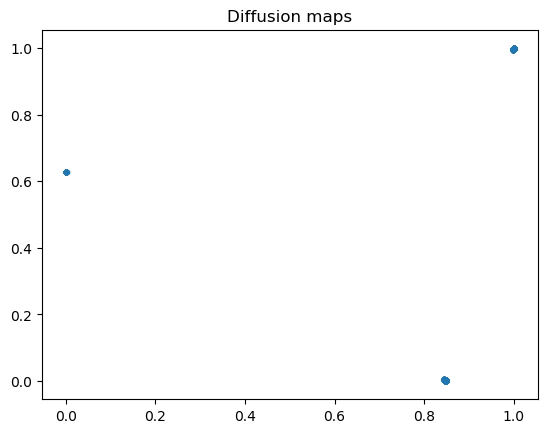

0.0 ,the imag of eigenvector : 0.0


PyObject Text(0.5, 1, 'Diffusion maps')

In [6]:
c = 2 ;
y_train = DiffMap(x_train , c , 7) ;

# Here we normalize the coordinates to 0~1
Ym = minimum(y_train , dims = 1) ;
YM = maximum(y_train , dims = 1) ;
y_train = (y_train .- Ym) ./ (YM - Ym) ;

scatter(y_train[:,1] , y_train[:,2] , s = 10)
title("Diffusion maps")

## Neural network model

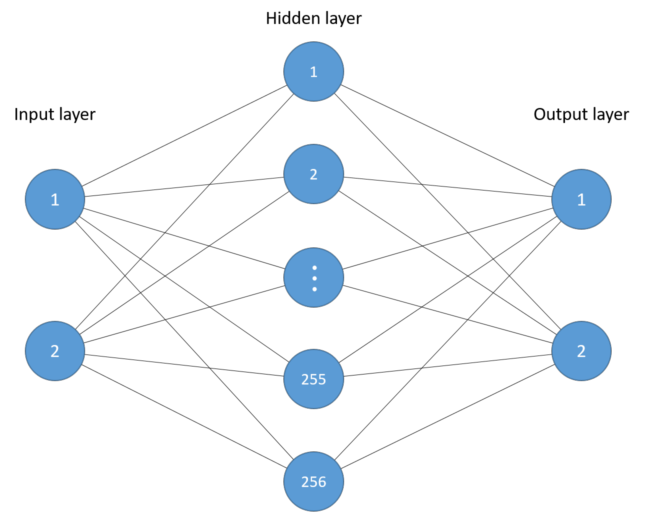

In [57]:
# model
load("model256.png") 

**optimizer:** Stochastic Gradient Descent(sgd)  
**loss function:** Mean squared error  
**activate function:** sigmoid  

In [8]:
function sigmoid(x , W , b)

    return 1 ./ (1 .+ exp.(-(W * x .+ b))) ;
end

sigmoid (generic function with 1 method)

In [26]:
function Stochastic_Gradient_Descent(x , y ; batch_size , epoch , eta)
    
    # Initialize weights and biases 
    s = 256 ; rng = MersenneTwister(1234) ;
    
    W2 = 0.5*randn(rng , s , size(x , 2))  ;
    W3 = 0.5*randn(rng , size(y , 2) , s) ;
    b2  = 0.5*randn(rng , s ) ;
    b3  = 0.5*randn(rng , size(y , 2) ) ;
    
    # cost function
    function cost(W2 , W3 , b2 , b3)
        
        train_loss = 0 ;
        for i = 1 : N
            a2 = sigmoid(x[i , :] , W2 , b2) ;
            a3 = sigmoid(a2 , W3 , b3) ;
            train_loss = train_loss + sum((y[i , :] .- a3) .^ 2) ;
        end
        
        return train_loss / N ;
    end
    
    # Forward and Back propagate 
    N = size(x , 1) ;
    K = N / batch_size ;
    train_cost = zeros(epoch , 1) ;
    
    for s = 1 : epoch
        idx = randperm(N) ;
        t = 1 ;
        for ii = 1 : K
            temp1 = 0 ; temp2 = 0 ; temp3 = 0 ; temp4 = 0 ;
            for jj = 1 : batch_size
                # Forward pass
                a2 = sigmoid(x[idx[t] , :] , W2 , b2) ;
                a3 = sigmoid(a2 , W3 , b3) ;
                # Backward pass
                delta3 = a3 .* (1 .- a3) .* (a3 - y[idx[t] , :]) ;
                delta2 = a2 .* (1 .- a2) .* (transpose(W3) * delta3) ;
                # Summation
                temp1 = temp1 .+ delta2 * transpose(x[idx[t] , :]) ;
                temp2 = temp2 .+ delta3 * transpose(a2) ;
                temp3 = temp3 .+ delta2 ;
                temp4 = temp4 .+ delta3 ;
                t = t+1 ;
            end
            # Gradient step
            W2 = W2 .- eta * temp1 / batch_size ;
            W3 = W3 .- eta * temp2 / batch_size ;
            b2  = b2 .- eta * temp3 / batch_size ;
            b3  = b3 .- eta * temp4 / batch_size ;
    
        end
        # Monitor progress
        train_cost[s] = cost(W2 , W3 , b2 , b3) ;
    end
    
    return W2 , W3 , b2 , b3 , train_cost ;
    
end

Stochastic_Gradient_Descent (generic function with 1 method)

## training
**mini batch:** 10  
**epoch:** 30000  
**learning rate:** 0.1

In [27]:
W2 , W3 , b2 , b3 , train_cost = Stochastic_Gradient_Descent(x_train , y_train , batch_size = 10 , epoch = 30000 , eta = 0.1) ;

## predict

In [28]:
# use original data

y_test = zeros(size(X , 1) , c)
for ii = 1 : size(X , 1)
    a2 = sigmoid(X[ii , :] , W2 , b2) ;
    y_test[ii , :] = sigmoid(a2 , W3 , b3) ;
end

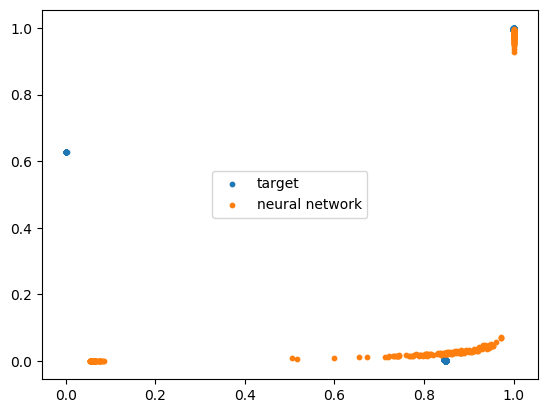

PyObject <matplotlib.legend.Legend object at 0x000000000148DB38>

In [29]:
figure(1)
scatter(y_train[:,1] , y_train[:,2] , s = 10 , label = "target")
scatter(y_test[:,1] , y_test[:,2] , s = 10 , label = "neural network")
legend(loc = 10)

## loss process

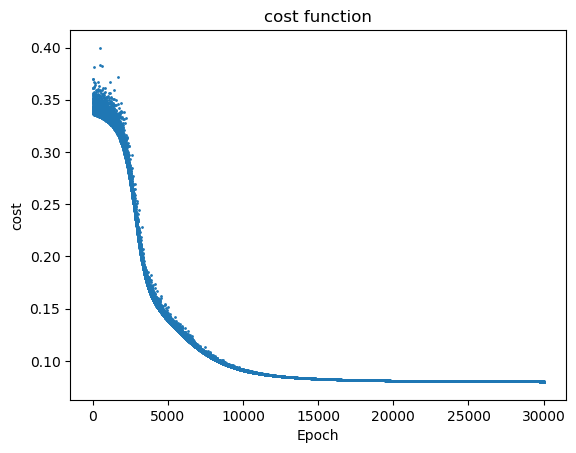

In [30]:
scatter(1 : size(train_cost,1) , train_cost , s = 1 )
title("cost function") ; xlabel("Epoch") ; ylabel("cost") ;

## K-means

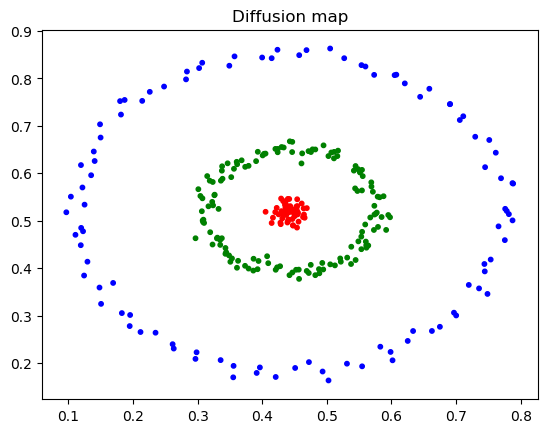

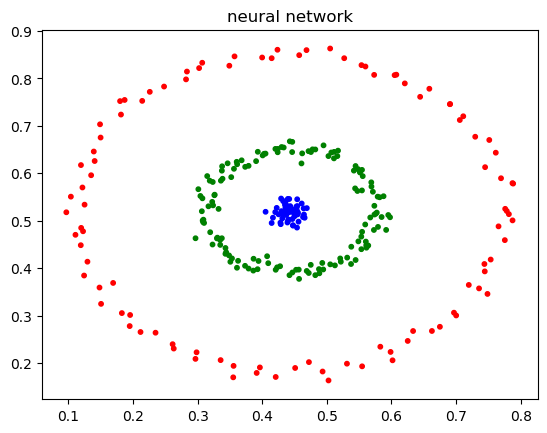

the imag of eigenvalue : 0.0 ,the imag of eigenvector : 0.0


PyObject Text(0.5, 1, 'neural network')

In [41]:
Y = DiffMap(X , 3 , 7) ;
R_target = kmeans(transpose(Y) , 3 ) ;
R_test     = kmeans(transpose(y_test) , 3 ) ;

scatter(X[:,1] , X[:,2] , c = Color1(R_target.assignments) , s = 10)
title("Diffusion map")
figure()
scatter(X[:,1] , X[:,2] , c = Color1(R_test.assignments) , s = 10)
title("neural network")